<a href="https://colab.research.google.com/github/glasgowlab/MAGPIE/blob/GoogleColab/MAGPIE_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/glasgowlab/MAGPIE/blob/GoogleColab/magpie_logo.png?raw=1" alt= “magpie_logo” width="100" align="right">

## **MAGPIE: an interactive tool for visualizing and analyzing many simultaneous protein interactions with a binding partner**

**What is this tool?**

MAGPIE is an online tool hosted on Google Colab that generates 3D visualizations for sets of protein binders interacting with one target ligand (which can be a protein or a small molecule). It also produces sequence logo-style amino acid (AA) frequency graphs. In the AA frequency graphs, the user chooses target ligand positions on the fly, and the size of each binder AA is based on the frequency that it appears in the protein complex dataset within a user-defined distance from the chosen target ligand position(s). The distance is calculated using the alpha carbon positions between protein interfaces, or all heavy atoms in the case of ligands. MAGPIE's 3D visualizer plots the entire target structure, and highlights the residues within a specified distance constraint. There are two options for coloring the interacting residues based on [Amino colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#aminocolours) and [Shapely colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#shapelycolours). If you prefer to keep the data private, or have >1000 input PDB files, it is better to clone the [local version](https://github.com/glasgowlab/MAGPIE/tree/local-version).

**Required inputs:**
- PDB files: these should be aligned on the target ligands. Two examples are provided on GitHub, one for protein-protein interactions and one for small molecule-protein interactions.
- Target chain ID from PDB: the program uses the first file in the directory to upload the target ligand structure.
- Protein binder chain ID from PDB: this chain identifier must be the same across all PDB files.
- Target type: indicate whether the target ligand is a small molecule or a protein.
- Target residue index (for protein ligands) or unique atom names (for small molecule ligands): provide the target residue indices for proteins or unique atom names for small molecules. Alternatively, you can input 'all' to consider all AAs/heavy atoms.

**Usage:**
Please execute the cells in numerical order. If you wish to load a different dataset, start from the upload step to reload the new data.


In [ ]:
#@title ##1. Install and import required packages.
%%capture

from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/glasgowlab/MAGPIE.git
%cd MAGPIE
!pip install logomaker
!pip install rarfile
!pip install biopython

import pandas as pd
import helper_functions
import sequence_logo_main
import os
import glob
import zipfile
import tarfile
import rarfile
%matplotlib notebook
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
try:
  os.mkdir('temp')
except:
  print("Done")



In [ ]:
#@title ##2. Upload and process data.
# @markdown Navigate to the File menu located top left of the screen. Upload data into the **temp** directory, in the form of a compressed directory in .zip format containing the PDB input files. It is also possible to directly upload the PDB files into the temp folder, but this might take a long time depending on the number of files.
# @markdown
# @markdown   There are two example datasets to test MAGPIE: a small molecule-protein example and a protein-protein example.
# @markdown
# @markdown    Select which dataset you would like to use:
import zipfile


def extract_file(archive_path, output_folder):
    if zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)
    else:
        print(f"{archive_path} is not a zip file")

uploaded_data_set = True #@param {type:"boolean"}
protein_protein_example = False  #@param {type:"boolean"}
small_molecule_ligand_example = False  #@param {type:"boolean"}
if uploaded_data_set:
  zip_files = glob.glob("temp/" +"*.zip")
  files = zip_files
  pdb_files =[]
  for file in files:
      extract_file(file, "temp")
      file = file.split(".zip")[0]
      pdb_files +=  glob.glob(file + "/*.pdb")

elif small_molecule_ligand_example:
  pdb_files = glob.glob("Small molecule example/reference_1/*.pdb")
elif protein_protein_example:
  pdb_files = glob.glob("Protein Example/" + "*.pdb")

print(pdb_files)

['temp/reference_2/4xz3_cleanedreference_2.pdb', 'temp/reference_2/7mss_cleanedreference_2.pdb', 'temp/reference_2/7cw5_cleanedreference_2.pdb', 'temp/reference_2/7lcl_cleanedreference_2.pdb', 'temp/reference_2/7ldu_cleanedreference_2.pdb', 'temp/reference_2/2vtz_cleanedreference_2.pdb', 'temp/reference_2/1jll_cleanedreference_2.pdb', 'temp/reference_2/6bja_cleanedreference_2.pdb', 'temp/reference_2/2hqy_cleanedreference_2.pdb', 'temp/reference_2/6aqp_cleanedreference_2.pdb', 'temp/reference_2/8ciw_cleanedreference_2.pdb', 'temp/reference_2/7ld2_cleanedreference_2.pdb', 'temp/reference_2/2scu_cleanedreference_2.pdb', 'temp/reference_2/7ldc_cleanedreference_2.pdb', 'temp/reference_2/2wkt_cleanedreference_2.pdb', 'temp/reference_2/1qfl_cleanedreference_2.pdb', 'temp/reference_2/4yak_cleanedreference_2.pdb', 'temp/reference_2/2f2s_cleanedreference_2.pdb', 'temp/reference_2/2nu7_cleanedreference_2.pdb', 'temp/reference_2/6pfn_cleanedreference_2.pdb', 'temp/reference_2/4xyl_cleanedreference

In [ ]:
#@title ##3. Select target ligand and protein binder chains.

# @markdown Select target ligand and protein binder chains, decide whether the target ligand is a ligand or protein, provide heavy atom names (if small molecule ligand) or residue index (if protein ligand) to plot around, and provide the distance in Ångstroms to graph from the target chain.

#@markdown You can also type 'all' to plot all residues or atoms.

# @markdown For the protein target example, use A for the target ligand chain and C for the protein binder chain.

# @markdown For the small molecule target example, use B for the target chain and C for the protein binder chain. Check the is_ligand option.

target_chain = "B"#@param {type:"string"}
binding_chain = "C"#@param {type:"string"}
download_meta = True #@param {type:"boolean"}

is_ligand = True #@param {type:"boolean"}
distance = '8' #@param {type:"string"}
distance = int(distance)

eps = 2
min_samples = 15


# @markdown MAGPIE uses DBSCAN to cluster points in 3d without requiring to specify the number of desired clusters.

# @markdown Run the followng cell if you are interested in changing:

# @markdown eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

# @markdown min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.


# @markdown Default is eps = 2.0, min_samples = 15

eps = '3' #@param {type:"string"}
min_samples = '5' #@param {type:"string"}

eps = float(eps)
min_samples = int(15)

In [ ]:
#@title #4. Plot points in 3D viewer.
# @markdown This might take a couple of minutes depending on the size of the dataset. It takes around one minute for the protein-protein example.
from matplotlib.pyplot import plot
# configure_plotly_browser_state()
import matplotlib.pyplot as plt

color_key = {
    'Hydrophobic': '#00008B',  # Dark Blue
    'Hydrophilic': '#D02090',  # Pink
    'Aromatic': '#008000',  # Green
    'Charged interactions': '#FF0000',  # Red
}

def plot_cluster_compositions(cluster_compositions_dict):
    # Create a single figure and axis
    fig, ax = plt.subplots(figsize=(15, len(cluster_compositions_dict) * 2))  # Adjusted figsize for larger single plots

    # Define the color for each composition entry
    composition_colors = [color_key['Hydrophobic'], color_key['Hydrophilic'],
                          color_key['Aromatic'], color_key['Charged interactions']]

    # Sort the clusters to maintain order
    sorted_cluster_indexes = sorted(cluster_compositions_dict.keys())

    # Calculate the height of each bar so that there is no space between them
    bar_height = 1.0

    # Loop through each cluster and its composition
    for cluster_index in sorted_cluster_indexes:
        composition = cluster_compositions_dict[cluster_index]
        # The starting point for each bar segment
        left = 0
        # Create each segment of the bar

        for comp, color in  zip(composition, composition_colors):
            ax.barh(cluster_index, comp, height=bar_height, color=color, left=left, edgecolor='white')
            left += comp  # Increment the left position

    # Set the labels and ticks
    ax.set_xlabel('Proportion')
    ax.set_yticks(sorted_cluster_indexes)  # Set y-ticks to cluster indexes
    ax.set_yticklabels([f'Cluster {i}' for i in sorted_cluster_indexes])

    # Remove the spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Create a legend, moved further down by adjusting the bbox_to_anchor parameter
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_key[label]) for label in color_key]
    labels = ["Hydrophobic (G,A,V,C,P,L,I,M)", "Hydrophilic (S,T,N,Q)", "Aromatic (W,F,S)", "Charged (D,E,K,R,H)"]
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(color_key))
    # Adjust the layout
    plt.tight_layout()
    # Show the plot
    filename = "clusters.png"
    plt.savefig(filename)
df_target,df_binder,return_from_clusters = sequence_logo_main.plot(pdb_files, target_chain,binding_chain,is_ligand, distance, download_meta,[eps,min_samples])
graph = False
from IPython.display import Image
if len(return_from_clusters) > 0 :
  plot_cluster_compositions(return_from_clusters)
  graph = True
else:
  print("No clusters were found, please change clustering settings or increase dataset size.")


<IPython.core.display.Javascript object>

800 106


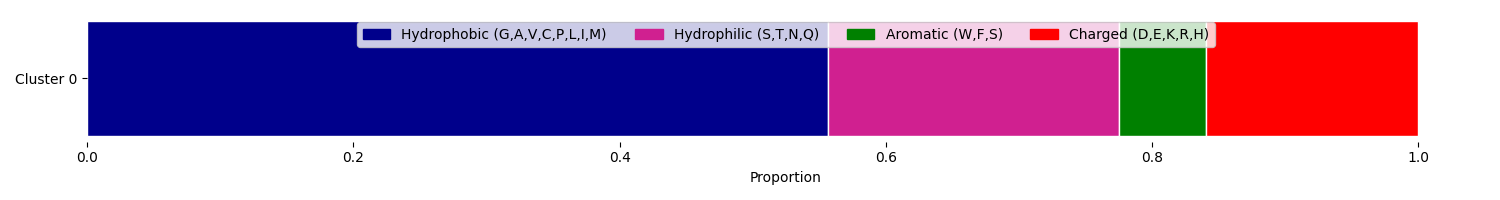

In [ ]:
#@title #4.2 Plot clusters
from IPython.display import Image
import os
import sys
from IPython.display import Image as IPyImage
from PIL import Image as PILImage

def display_image_auto_size(image_path):
    """
    Display an image in a Jupyter notebook with automatic width and height adjustment based on the original size.

    Parameters:
        image_path (str): Path to the image file.
    """
    # Open the image file using PIL
    img = PILImage.open(image_path)

    # Get the original width and height of the image
    original_width, original_height = img.size


    max_width = 800
    max_height = 600

    # Calculate the new width and height based on the original aspect ratio
    if original_width > original_height:
        # Landscape orientation
        new_width = min(original_width, max_width)
        new_height = int((original_height / original_width) * new_width)
    else:
        # Portrait or square orientation
        new_height = min(original_height, max_height)
        new_width = int((original_width / original_height) * new_height)

    # Display the image with the adjusted width and height
    print(new_width, new_height)
    return IPyImage(filename=image_path, width=new_width, height=new_height)
image_path = 'clusters.png'

if not os.path.isfile(image_path):
  sys.exit("No clusters were found.")

display_image_auto_size(image_path)

In [ ]:


#@title #5. Select target ligand residues or heavy atoms to generate AA frequency graphs.
# @markdown Enter the target residue indices or heavy atom names to graph. These should be separated by commas, without spaces (e.g., N1A,N3A,N9A). Ranges are allowed when working with protein-protein interactions (e.g. 127-131,146-149).
import helper_functions

# @markdown If there are no residues within the given range, the next cell will not execute.
sequence_logo_targets = "H14,H17,S1P,O5P,OAP,H1B,H1A"#@param {type:"string"}




No AA within 8 Å of target id: H14
No AA within 8 Å of target id: H17
No AA within 8 Å of target id: H1A


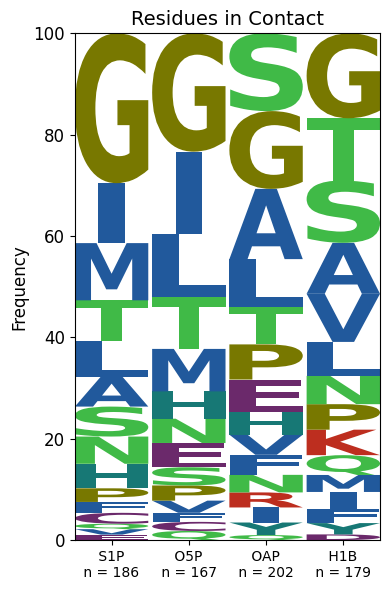

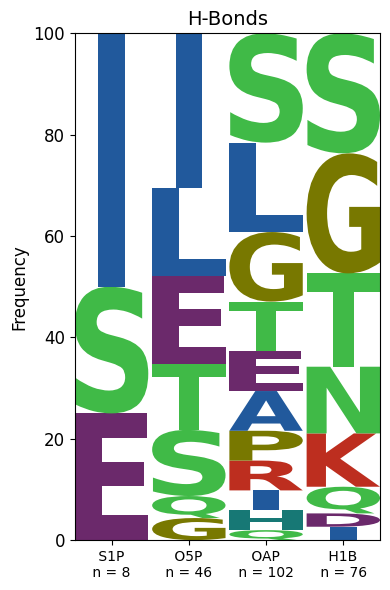

In [ ]:
#@title #5.  Generate AA frequency graphs.
# @markdown Select if you'd like to only see the combined AA frequency graph.
from IPython.core.pylabtools import figsize
figsize(2, 6)
combined = True #@param {type:"boolean" }
plot_list = helper_functions.process_residues_to_graph(sequence_logo_targets,is_ligand)

%matplotlib inline
sequence_logos(df_target,df_binder, plot_list, is_ligand,combined, distance)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul  4 17:18:58 2023

@author: camlo
"""
import os.path
import sys
import hbonds_saltbridges
import Bio.PDB.PDBParser
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import pandas as pd
import glob
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import math
import logomaker
import numpy as np
import helper_functions
from Bio import *
import plotly.offline as py
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.cluster import DBSCAN
import warnings
import multiprocessing

warnings.simplefilter(action='ignore', category=FutureWarning)
aa_mapping = {
    'ALA': 'A',

    'ARG': 'R',
    'ASN': 'N',
    'ASP': 'D',
    'CYS': 'C',
    'GLN': 'Q',
    'GLU': 'E',
    'GLY': 'G',
    'HIS': 'H',
    'ILE': 'I',
    'LEU': 'L',
    'LYS': 'K',
    'MET': 'M',
    'PHE': 'F',
    'PRO': 'P',
    'SER': 'S',
    'THR': 'T',
    'TRP': 'W',
    'TYR': 'Y',
    'VAL': 'V'
}

amino_acid_classes = {
    'G': 'Hydrophobic',
    'A': 'Hydrophobic',
    'V': 'Hydrophobic',
    'C': 'Hydrophobic',
    'P': 'Hydrophobic',
    'L': 'Hydrophobic',
    'I': 'Hydrophobic',
    'M': 'Hydrophobic',
    'W': 'Aromatic',
    'F': 'Aromatic',
    'S': 'Hydrophilic',
    'T': 'Hydrophilic',
    'Y': 'Aromatic',
    'N': 'Hydrophilic',
    'Q': 'Hydrophilic',
    'D': 'Charged interactions',
    'E': 'Charged interactions',
    'K': 'Charged interactions',
    'R': 'Charged interactions',
    'H': 'Charged interactions'
}


def create_3d_graph(df1, df2, is_ligand, ligand_bonds={}, name_file="3d_scatter"):
    # Get XYZ positions from the DataFrame columns
    x1, y1, z1 = df1['X'], df1['Y'], df1['Z']
    x2, y2, z2 = df2['X'], df2['Y'], df2['Z']
    color_shapely = df1['shapely'].values.tolist()
    color_polar = df1['polar'].values.tolist()
    color_hb = df1['H-bond'].values.tolist()
    color_cluster = df1["cluster_color"].values.tolist()
    cluster_names = df1["cluster_index"].values.tolist()

    if is_ligand:
        names = df2['atom_name'].values.tolist()
        color_df2 = df2["color"].values.tolist()
        size2 = 15
    else:
        names = df2['residue_index'].values.tolist()
        color_df2 = "black"
        size2 = 15
        color_salt = df1['Salt Bridge'].values.tolist()
    # init_notebook_mode(connected=True)
    scatter_trace1 = go.Scatter3d(
        x=x1,
        y=y1,
        z=z1,
        mode='markers',
        marker=dict(
            size=9,
            color=color_shapely,
            opacity=1,
            line=dict(color='black', width=2)
        ),
        text=df1['AA'],
        hoverinfo='text',
        hoverlabel=dict(bgcolor='yellow', bordercolor='black'),
        name="Binding Residues"
    )

    scatter_trace2 = go.Scatter3d(
        x=x2,
        y=y2,
        z=z2,
        mode='markers',
        marker=dict(
            size=size2,
            color=color_df2,
            opacity=1,
            line=dict(color='white', width=5)
        ),
        text=names,
        hoverinfo='text',
        hoverlabel=dict(bgcolor='gray', bordercolor='white'),
        name="Target"

    )
    buttons = []
    buttons.append(dict(label='Shapely Colours', method='restyle',
                        args=[{'text': [df1['AA']], "marker.color": [color_shapely]}, [0]]))
    buttons.append(
        dict(label='Amino Colours', method='restyle', args=[{'text': [df1['AA']], 'marker.color': [color_polar]}, [0]]))
    buttons.append(
        dict(label='H-Bond', method='restyle', args=[{'text': [df1['AA']], 'marker.color': [color_hb]}, [0]]))
    if not is_ligand:
        buttons.append(dict(label='Salt-Bridges', method='restyle',
                            args=[{'text': [df1['AA']], 'marker.color': [color_salt]}, [0]]))
    buttons.append(dict(label='Hotspots', method='restyle',
                        args=[{'text': [cluster_names], 'marker.color': [color_cluster]}, [0]]))

    updatemenus = [
        dict(buttons=buttons, showactive=True),
        dict(direction='down', x=0.1, xanchor='left', y=1.1, yanchor='top'),
    ]

    # Create the layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            camera=dict(
                eye=dict(x=2, y=-2, z=1.5)  # Adjust the eye position to view all eight regions
            )
        ),
        title='MAGPIE'
    )
    graphs = [scatter_trace1, scatter_trace2]


    if not is_ligand:
        line_trace_target = go.Scatter3d(
            x=x2,
            y=y2,
            z=z2,
            mode='lines',
            line=dict(
                color='black',  # Choose a color that stands out
                width=8  # Adjust line width as needed
            ),
            hoverinfo='skip',  # Optionally disable hover info for the lines
            showlegend=False  # Optionally hide the line trace from the legend
        )
        graphs.append(line_trace_target)
    else:
        if len(ligand_bonds ) == 0:
            points = np.array([x2, y2, z2]).T
            for i in range(len(points)):
                for j in range( len(points)):
                    # Check if either of the points is named 'H'
                    if 'H' in names[i] or  "H" in names[j]:
                        continue
                    # Check if the points are within the distance threshold
                    if euclidean_distance(points[i], points[j]) <= 2:
                        # Add a line between the points
                        line_trace = go.Scatter3d (
                            x=[points[i][0], points[j][0]],
                            y=[points[i][1], points[j][1]],
                            z=[points[i][2], points[j][2]],
                            mode='lines',
                            line=dict(color='black', width=8),
                            hoverinfo='skip',
                            showlegend=False
                        )
                        graphs.append(line_trace)

        else:
            for bond in ligand_bonds:
                for pair in ligand_bonds[bond]:
                    atom_coords1 = df2.loc[df2['atom_serial_number'] == str(bond)]
                    atom_coords2 = df2.loc[df2['atom_serial_number'] == str(pair)]
                    point1 = atom_coords1[['X', 'Y', 'Z']].values
                    point2 = atom_coords2[['X', 'Y', 'Z']].values
                    line_trace = go.Scatter3d(
                        x=[point1[0][0], point2[0][0]],
                        y=[point1[0][1], point2[0][1]],
                        z=[point1[0][2], point2[0][2]],
                        mode='lines',
                        line=dict(color='black', width=8),
                        hoverinfo='skip',
                        showlegend=False
                    )

                    graphs.append(line_trace)

    # Create the figure and add the traces
    fig = go.Figure(data=graphs, layout=layout)
    fig.update_layout(updatemenus=updatemenus)
    # Show the interactive plot
    fig.show()


def find_nearest_points(target, binders, radius):
    target_points_in_contact = []
    binder_points_in_contact = []

    for i in range(0, len(target)):
        # Create KDTree for binder_points
        # Query binders DataFrame within the specified radius of target_point
        current_target = target.iloc[i]
        current_binder = binders.iloc[i]
        pd.set_option('display.max_colwidth', None)

        binder_points = []
        target_points = []

        for row in current_binder:

            if row is not None and len(row.keys()) != 0:
                binder_points.append([row['X'], row['Y'], row['Z']])
        for row in current_target:
            if row is not None and len(row.keys()) != 0:
                target_points.append([row['X'], row['Y'], row['Z']])

        tree = KDTree(np.array(binder_points))

        indices = tree.query_ball_point(np.array(target_points), r=radius)
        targets_in_contact = []
        binder_in_contact = []

        for i, index in enumerate(indices):
            if len(index) == 0:
                continue
            targets_in_contact.append(i)
            binder_in_contact += index

        target_points_in_contact.append(sorted(list(set(targets_in_contact))))
        binder_points_in_contact.append(sorted(list(set(binder_in_contact))))

    return target_points_in_contact, binder_points_in_contact


def get_coords_from_row(row):
    return [row['X'], row['Y'], row['Z']]


def calculate_arrow_position(subplot_index):
    arrow_x = (subplot_index - 1) * 0.25 + 0.1
    arrow_tail_x = arrow_x + 0.1
    return arrow_x, arrow_tail_x


def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def transform_to_1_letter_code(amino_acids_3_letter):
    # Mapping dictionary for 3-letter to 1-letter code

    amino_acids_1_letter = [aa_mapping.get(aa,"?") for aa in amino_acids_3_letter]
    return amino_acids_1_letter

def find_points_within_radius(binder_point, target_points, radius):
    # Convert the binder_point DataFrame to a NumPy array
    binder_np = np.array(binder_point[['X', 'Y', 'Z']])

    # Convert the target_points DataFrame to a NumPy array
    target_np = np.array(target_points[['X', 'Y', 'Z']])

    # Build a KDTree from the binder point
    tree = KDTree(binder_np)

    # Query the KDTree to find indices of points within the specified radius
    indices = tree.query_ball_point(target_np, r=radius)

    # Create a list to store the points within radius for each target point
    points_within_radius = []

    # Iterate through the indices and extract the corresponding target points
    for i, index_list in enumerate(indices):
        if len(index_list) == 0:
            continue
        points_within_radius.append(i)

    residues_points = target_points.iloc[points_within_radius]
    return residues_points


def find_closest_point(df1, df2, is_ligand):
    # Filter df2 to exclude rows where "atom_name" contains "H" if is_ligand is True
    if is_ligand:
        df2 = df2[~df2['atom_name'].str.contains("H", na=False)]
    # Calculate the average position in df1
    avg_position = df1[['X', 'Y', 'Z']].mean().values
    # Convert df2 to a NumPy array
    df2_np = np.array(df2[['X', 'Y', 'Z']])
    # Build a KDTree from df2
    tree = KDTree(df2_np)
    # Query the KDTree to find the index of the closest point in df2 to the average position in df1
    closest_index = tree.query(avg_position)[1]
    # Get the closest point from df2
    closest_point = df2.iloc[closest_index]
    return closest_point


def calculate_frequency(character, lst):
    count = lst.count(character)

    frequency = count / len(lst)

    return frequency


def calculate_bits(list_of_AA, sequence_list):
    list_of_frequencies = []
    for AA in list_of_AA:
        list_of_frequencies.append(calculate_frequency(AA, sequence_list))

    heights = []
    for f in list_of_frequencies:
        heights.append(np.abs(f * 100))
    return heights


def remove_items(test_list, item):
    # remove the item for all its occurrences
    c = test_list.count(item)
    for i in range(c):
        test_list.remove(item)
    return test_list


def create_sequence_logo_list(data, only_combined, is_ligand):
    # Titles for each type of graph
    axis_label_fontsize = 12
    title_fontsize =14
    xtick_label_fontsize = 10
    y_lable_size = 12
    ytick_label_fontsize = 12
    titles = ["Residues in Contact", "H-Bonds", "Salt Bridges"]
    for j, row in enumerate(data):
        # Filter out the [None, None] graphs
        valid_graphs = []
        title_row = []
        for i, graph in enumerate(row):
            if graph[1] != None:
                valid_graphs.append(graph)
                title_row.append(titles[i])
        num_graphs = len(valid_graphs)

        # Only create subplots for the valid graphs
        if num_graphs > 0:
            if j == 0:
                for i, graph in enumerate(valid_graphs):
                    fig, ax = plt.subplots(figsize=(1 * len(graph[1]), 6))  # Adjust the size as needed

                    # Create the logo with logomaker
                    logo = logomaker.Logo(graph[0], ax=ax, color_scheme='NajafabadiEtAl2017', shade_below=0.5)
                    logo.ax.set_ylabel('Frequency', fontsize=y_lable_size)

                    # Set x-ticks and labels
                    positions = [k for k in range(len(graph[1]))]
                    logo.ax.set_xticklabels(graph[1], fontsize=xtick_label_fontsize)  # Rotate labels for visibility
                    logo.ax.set_xticks(positions)
                    ax.yaxis.set_tick_params(labelsize=ytick_label_fontsize)

                    # Set the title for this subplot
                    ax.set_title(title_row[i], fontsize=title_fontsize)
                    plt.tight_layout()
                    plt.show()
                if only_combined:
                    break
                else:
                    continue

            fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 6))

            fig.subplots_adjust(hspace=1.0)  # Increase the height space between rows

            if num_graphs == 1:
                axs = [axs]  # Make sure axs is iterable

            for i, graph in enumerate(valid_graphs):
                ax = axs[i]  # Select the subplot
                # Create the logo with logomaker
                logo = logomaker.Logo(graph[0], ax=ax, color_scheme='NajafabadiEtAl2017', shade_below=0.5)
                logo.ax.set_ylabel('Frequency', fontsize=axis_label_fontsize)

                # Set x-ticks and labels
                positions = [k for k in range(len(graph[1]))]
                logo.ax.set_xticklabels(graph[1], fontsize=xtick_label_fontsize)  # Rotate labels for visibility
                logo.ax.set_xticks(positions)

                # Set the title for this subplot
                ax.set_title(title_row[i], fontsize=title_fontsize)
            plt.tight_layout()
            plt.show()  # Display the plot for this row
        if only_combined:
            break


def assing_class_for_cluster(AA_list):
    cluster_info = {}
    count_hydropho = 0
    count_hydrophi = 0
    aromatic = 0
    charged = 0
    no_res = 0
    for AA in AA_list:
        if AA == "?":
            no_res += 1
            continue
        if amino_acid_classes[AA] == "Hydrophobic":
            count_hydropho+=1
        elif amino_acid_classes[AA] == "Hydrophilic":
            count_hydrophi += 1
        elif amino_acid_classes[AA] == "Aromatic":
            aromatic += 1
        else:
            charged += 1
    total = len(AA_list) - no_res
    hydrophi_width =  count_hydrophi/total
    hydropho_width = count_hydropho/total
    aromatic_width= aromatic/total
    charged_width = charged/total


    return [hydropho_width,hydrophi_width,aromatic_width,charged_width]



def add_mapped_column(df, column_to_map, mapping_dict, new_column_name):
    # Use the map method to create a new column based on the existing one
    df[new_column_name] = df[column_to_map].map(mapping_dict)
    return df


def map_colors(df, color_key):
    # Function to apply the color mapping with the exception
    def color_for_row(row):
        if row['cluster_index'] == -1:
            return '#FFFFFF'  # White color for the exception case
        else:
            return color_key.get(row['AA Class'], "#FFFFFF")  # You can set a default color

    # Apply the function to each row
    df['cluster_color'] = df.apply(color_for_row, axis=1)
    return df


def assign_cluster_colors(dataframe):
    # Get unique clusters excluding the noise (-1)
    unique_clusters = dataframe['cluster_index'].unique().tolist()
    widths = {}
    dataframe = add_mapped_column(dataframe, "AA", aa_mapping, "AA1")
    dataframe = add_mapped_column(dataframe, "AA1", amino_acid_classes, "AA Class")
    dataframe = map_colors(dataframe, color_key)
    for unique_cluster in unique_clusters:
        if unique_cluster == -1:
            continue
        cluster_df = dataframe[dataframe["cluster_index"] == unique_cluster]
        AA_list = transform_to_1_letter_code(cluster_df['AA'].values.tolist())
        colors = assing_class_for_cluster(AA_list)
        widths[unique_cluster] = colors
    return [dataframe, widths]


def map_column_with_dict(dataframe, mapping_dict, target_column, new_column_name):
    """
    Maps values in a specified column of a DataFrame according to a provided dictionary,
    and creates a new column with these mapped values.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to operate on.
    - mapping_dict (dict): A dictionary where keys are the values to be mapped from the target_column
                           and values are the corresponding new values for the new_column.
    - target_column (str): The name of the column in the DataFrame whose values are to be mapped.
    - new_column_name (str): The name of the new column that will be created with mapped values.

    Returns:
    - pd.DataFrame: The original DataFrame with the new column added.
    """

    # Check if the target column exists in the DataFrame
    if target_column not in dataframe.columns:
        raise ValueError(f"Column '{target_column}' not found in DataFrame")

    # Map the target column values to the new column using the provided dictionary
    dataframe[new_column_name] = dataframe[target_column].map(mapping_dict)

    return dataframe


def cluster_3d_points(dataframe, advance_options=[2, 10]):
    # Ensure the DataFrame has the correct column names
    if not set(['X', 'Y', 'Z']).issubset(dataframe.columns):
        raise ValueError("Dataframe must contain 'X', 'Y', and 'Z' columns")

    # Extract the points from the dataframe
    points = dataframe[['X', 'Y', 'Z']].values

    # Apply DBSCAN clustering
    # The parameters `eps` and `min_samples` need to be chosen based on the dataset.
    # These are common starting values, but for optimal results they should be fine-tuned
    dbscan = DBSCAN(eps=advance_options[0], min_samples=advance_options[1], algorithm="kd_tree")
    dbscan.fit(points)

    # Add the cluster index to the dataframe
    dataframe['cluster_index'] = dbscan.labels_

    # Return the dataframe with the new 'cluster_index' column
    return dataframe


def amino_acid_statistics_per_list(list_of_lists):
    # Define all 20 amino acids (1-letter codes)
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # Initialize dictionaries to hold counts and frequencies for each sublist
    counts_per_list = {f'n{aa}': [] for aa in amino_acids}
    frequencies_per_list = {f'f{aa}': [] for aa in amino_acids}
    total_counts_per_list = []

    # Process each sublist
    for sublist in list_of_lists:
        sublist_count = {aa: 0 for aa in amino_acids}
        total_count = 0

        # Count amino acids in the sublist
        for aa in sublist:
            if aa in sublist_count:
                sublist_count[aa] += 1
                total_count += 1

        total_counts_per_list.append(total_count)

        # Calculate frequencies and update the counts for this sublist
        for aa in amino_acids:
            counts_per_list[f'n{aa}'].append(sublist_count[aa])
            frequency = sublist_count[aa] / total_count if total_count > 0 else 0
            frequencies_per_list[f'f{aa}'].append(frequency)

    # Combine the results into one dictionary
    stats_per_list = {**counts_per_list, **frequencies_per_list, 'total_counts': total_counts_per_list}
    return stats_per_list


# ef plot_cluster_compositions(cluster_compositions_dict):
#     # Create a single figure and axis
#     fig, ax = plt.subplots(figsize=(10, len(cluster_compositions_dict) * 1.5))  # Increased height for spacing
#
#     # Define the color for each composition entry
#     composition_colors = [color_key['Hydrophobic'], color_key['Hydrophilic'],
#                           color_key['Aromatic'], color_key['Charged interactions']]
#
#     # Sort the clusters to maintain order
#     sorted_cluster_indexes = sorted(cluster_compositions_dict.keys())
#
#     # Adjust the height of each bar so that there is a space between them
#     bar_height = 0.8  # Less than 1 to create a gap
#
#     # Loop through each cluster and its composition
#     for cluster_index in sorted_cluster_indexes:
#         composition = cluster_compositions_dict[cluster_index]
#         # The starting point for each bar segment
#         left = 0
#         # Create each segment of the bar, with space between them
#         for comp, color in zip(composition, composition_colors):
#             # The bars are centered on the y-tick, so subtracting half the bar height for the starting y position
#             ax.barh(cluster_index, comp, height=bar_height, color=color, left=left, edgecolor='white')
#             left += comp  # Increment the left position
#
#     # Set the labels and ticks
#     ax.set_xlabel('Proportion')
#     ax.set_yticks(sorted_cluster_indexes)  # Set y-ticks to cluster indexes
#     ax.set_yticklabels([f'Cluster {i}' for i in sorted_cluster_indexes])


def plot_cluster_compositions(cluster_compositions_dict):
    # Create a single figure and axis
    fig, ax = plt.subplots(figsize=(15, len(cluster_compositions_dict)))

    # Define the color for each composition entry
    composition_colors = [color_key['Hydrophobic'], color_key['Hydrophilic'],
                          color_key['Aromatic'], color_key['Charged interactions']]

    # Sort the clusters to maintain order
    sorted_cluster_indexes = sorted(cluster_compositions_dict.keys())

    # Calculate the height of each bar so that there is no space between them
    bar_height = 1.0

    # Loop through each cluster and its composition
    for cluster_index in sorted_cluster_indexes:
        composition = cluster_compositions_dict[cluster_index]
        # The starting point for each bar segment
        left = 0
        # Create each segment of the bar
        for comp, color in zip(composition, composition_colors):
            ax.barh(cluster_index, comp, height=bar_height, color=color, left=left, edgecolor='white')
            left += comp  # Increment the left position

    # Set the labels and ticks
    ax.set_xlabel('Proportion')
    ax.set_yticks(sorted_cluster_indexes)  # Set y-ticks to cluster indexes
    ax.set_yticklabels([f'Cluster {i}' for i in sorted_cluster_indexes])

    # Remove the spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Create a legend, moved further down by adjusting the bbox_to_anchor parameter
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_key[label]) for label in color_key]
    labels = ["Hydrophobic (G,A,V,C,P,L,I,M)", "Hydrophilic (S,T,N,Q)", "Aromatic (W,F,S)", "Charged (D,E,K,R,H)"]
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(color_key))
    # Adjust the layout
    plt.tight_layout()
    # Show the plot
    plt.show()



def plot(list_of_paths, target_id_chain, binder_id_chain, is_ligand, distance, download_meta, advance_options):
    chains_target = []
    chains_binder = []

    parser = Bio.PDB.PDBParser(QUIET=True)
    reference_id = 0
    current_len = 0
    bonds = {}
    for i, path in enumerate(list_of_paths):
        current_structure = parser.get_structure(i, path)
        chains_list = list(current_structure.get_chains())  # Convert iterator to list once here
        if len(chains_list) != 2:
            print(f"{path.split('/')[0]} contains {len(chains_list)} chains instead of expected 2.")
            exit(0)

        for chain in chains_list:
            current_chain_id = chain.get_id()

            if current_chain_id != target_id_chain and current_chain_id != binder_id_chain:
                print(
                    f"{path.split('/')[0]} contains chain {chain.get_id()}, which is not defined, please remove or rename chain.")
                exit(0)
            elif current_chain_id == target_id_chain:
                chains_target.append(chain)
                if len([x for x in chain]) > current_len:
                    reference_id = i
            elif current_chain_id == binder_id_chain:
                chains_binder.append(chain)
    target_chain_ca_coords = []
    binder_chain_ca_coords = []
    for i in range(0, len(chains_target)):
        if is_ligand:
            ligand_values = helper_functions.extract_info_ligand(list_of_paths[i], target_id_chain)
            target_chain_ca_coords.append(ligand_values[0])
            if i == reference_id:
                bonds = ligand_values[1]
        else:
            target_chain_ca_coords.append(
                helper_functions.extract_atoms_from_chain(chains_target[i], "CA", list_of_paths[i]))
        binder_chain_ca_coords.append(
            helper_functions.extract_atoms_from_chain(chains_binder[i], "CA", list_of_paths[i]))

    target_chain_data_frame = pd.DataFrame(target_chain_ca_coords)
    binder_chain_data_frame = pd.DataFrame(binder_chain_ca_coords)

    target_in_contact, binder_in_contact = find_nearest_points(target_chain_data_frame, binder_chain_data_frame,
                                                               distance)
    residues_to_plot = []

    for i in range(len(target_in_contact)):  # Every file
        residues_in_contact_binder = []
        residues_in_contact_target = []
        for k, residue in enumerate(chains_binder[i]):
            if k in binder_in_contact[i]:
                residues_in_contact_binder.append(residue)
        if is_ligand:
            residue = chains_target[i].get_residues().__next__()
            residues_in_contact_target.append(residue)
        else:
            for k, residue in enumerate(chains_target[i]):
                if k in target_in_contact[i]:
                    residues_in_contact_target.append(residue)
        for l in range(len(residues_in_contact_binder)):
            binder_h_bond_sc = False
            binder_h_bond_bb = False
            found_salt_bridge = False
            sb_info = ["", ""]
            bb_info = ["", ""]
            binder_residue = residues_in_contact_binder[l]
            for k in range(len(residues_in_contact_target)):
                target_residue = residues_in_contact_target[k]
                if not binder_h_bond_sc:
                    binder_h_bond_sc, sc_info = hbonds_saltbridges.find_hydrogen_bond(target_residue, binder_residue,
                                                                                      is_ligand, False)
                if not is_ligand:
                    if not binder_h_bond_bb:
                        binder_h_bond_bb, bb_info = hbonds_saltbridges.find_hydrogen_bond(target_residue,
                                                                                          binder_residue, is_ligand,
                                                                                          True)
                    if not found_salt_bridge:
                        found_salt_bridge, sb_info = hbonds_saltbridges.find_salt_bridge(target_residue, binder_residue)
                if k == len(residues_in_contact_target) - 1:
                    residue_found = binder_chain_data_frame.iloc[i][binder_in_contact[i][l]]
                    residue_found["H-Bond SC Info"] = f"Acceptor: {sc_info[0]}, donor {sc_info[1]}"
                    residue_found["H-Bond BB Info"] = f"Acceptor: {bb_info[0]}, donor {bb_info[1]}"
                    if (not sb_info[0] == "" or not bb_info[0] == "" or not sb_info[0] == "") and not is_ligand:
                        residue_found["Residue in target (Same PDB)"] = target_residue.get_full_id()[3][1]
                    if binder_h_bond_sc:
                        residue_found["H-Bond SC"] = '#FF0000'
                    else:
                        residue_found["H-Bond SC"] = '#FFFFFF'
                    if binder_h_bond_bb:
                        residue_found["H-Bond BB"] = '#FF0000'
                    else:
                        residue_found["H-Bond BB"] = '#FFFFFF'
                    if binder_h_bond_sc or binder_h_bond_bb:
                        residue_found["H-bond"] = "#FF0000"
                    else:
                        residue_found["H-bond"] = "#FFFFFF"
                    if not is_ligand and found_salt_bridge:
                        residue_found["Salt Bridge"] = "#FF0000"
                        residue_found["Salt Bridge Info "] = f"atom1: {sb_info[0]}, atom2  {sb_info[1]}"
                    if not is_ligand and not found_salt_bridge:
                        residue_found["Salt Bridge"] = "#FFFFFF"
                        residue_found["Salt Bridge Info"] = f"atom1: {sb_info[0]}, atom2  {sb_info[1]}"
                    residues_to_plot.append(residue_found)
                if binder_h_bond_sc and is_ligand:
                    residue_found = binder_chain_data_frame.iloc[i][binder_in_contact[i][l]]
                    residue_found["H-Bond SC"] = '#FF0000'
                    residue_found["H-Bond SC Info"] = f"Acceptor: {sc_info[0]}, donor {sc_info[1]}"
                    residue_found["H-Bond BB"] = '#FFFFFF'
                    residue_found["H-Bond BB Info"] = f"Acceptor: {sc_info[0]}, donor {sc_info[1]}"
                    residue_found["H-bond"] = "#FF0000"
                    residues_to_plot.append(residue_found)
                    break
                if binder_h_bond_sc and binder_h_bond_bb and found_salt_bridge:
                    residue_found = binder_chain_data_frame.iloc[i][binder_in_contact[i][l]]
                    residue_found["H-Bond BB"] = '#FF0000'
                    residue_found["H-Bond BB Info"] = f"Acceptor: {bb_info[0]}, donor {bb_info[1]}"
                    residue_found["H-Bond BB"] = '#FF0000'
                    residue_found["H-Bond BB Info"] = f"Acceptor: {bb_info[0]}, donor {bb_info[1]}"
                    residue_found["H-bond"] = '#FF0000'
                    residue_found["Residue in target (Same PDB)"] = target_residue.get_full_id()[3][1]
                    if not is_ligand:
                        residue_found["Salt Bridge"] = "#FF0000"
                        residue_found["Salt Bridge Info"] = f"atom1: {sb_info[0]}, atom2  {sb_info[1]}"
                    residues_to_plot.append(residue_found)
                    break

    polar_int_map = {}
    polar_int_map["#FF0000"] = "True"
    polar_int_map["#FFFFFF"] = "False"


    residue_found_df   = pd.DataFrame(residues_to_plot)
    residue_found_df = cluster_3d_points(residue_found_df, advance_options)
    return_from_clusters = assign_cluster_colors(residue_found_df)
    residue_found_df = return_from_clusters[0]
    target_to_to_plot = []
    clusters_ids = residue_found_df['cluster_index'].unique().tolist()
    clusters_ids.remove(-1)
    for x in target_chain_data_frame.iloc[reference_id]:
        if x is not None:
            target_to_to_plot.append(x)
    target_plot_df = pd.DataFrame(target_to_to_plot)
    name = list_of_paths[0].split("/")[-2]
    if download_meta:
        residue_found_df = map_column_with_dict(residue_found_df, polar_int_map, "H-Bond BB", "H-Bond BB Flag")
        residue_found_df = map_column_with_dict(residue_found_df, polar_int_map, "H-Bond SC", "H-Bond SC Flag")
        useless_columns = ["shapely", "polar", "H-Bond BB", "H-Bond SC", "H-bond", "cluster_color"]
        if not is_ligand:
            residue_found_df = map_column_with_dict(residue_found_df, polar_int_map, "Salt Bridge", "Salt Bridge Flag")
            useless_columns.append("Salt Bridge")
        residue_found_df_data = residue_found_df.copy()
        # residue_found_df_data.drop(useless_columns, axis=1, inplace=True)
        amino_acids = []
        closest_names = []
        for cluster_id in clusters_ids:
            filtered_cluster = residue_found_df[residue_found_df['cluster_index'] == cluster_id]
            closest_point = find_closest_point(filtered_cluster, target_plot_df, is_ligand)
            amino_acids.append(transform_to_1_letter_code(filtered_cluster['AA'].values.tolist()))
            if is_ligand:
                closest_name = closest_point["atom_name"]
            else:
                residue_index = str(closest_point["residue_index"])
                residue_name = aa_mapping[closest_point["AA"]]
                closest_name = residue_name+residue_index
            closest_names.append(closest_name)
        cluster_distribution = amino_acid_statistics_per_list(amino_acids)
        closest_point_dict = {}
        closest_point_dict["Hotspot Residue"] = closest_names
        closest_point_dict["Hotspot Index"] = clusters_ids
        closest_point_dict.update(cluster_distribution)
        cluster_df = pd.DataFrame(closest_point_dict)
        metadata_directory = f"meta_data_for_{name}"
        helper_functions.create_directory(metadata_directory)
        magpie_data_name = f"proximity_and_polar_metadata_for_{name}.csv"
        hotspost_data_name = f"hotspot_metadata_for{name}.csv"
        residue_found_df_data.to_csv(os.path.join(metadata_directory, magpie_data_name))
        cluster_df.to_csv(os.path.join(metadata_directory, hotspost_data_name))

    create_3d_graph(residue_found_df,target_plot_df, is_ligand,bonds, name)

    return residue_found_df,pd.DataFrame(target_chain_ca_coords[reference_id]), return_from_clusters[1]



def sequence_logos(residues_found, target_residues, sequence_logo_targets, is_ligand, only_combined_logo, radius ):

    warnings.filterwarnings("ignore")
    model = logomaker.get_example_matrix('ww_information_matrix',
                                         print_description=False)
    list_of_AA = model.columns.to_list()
    rows_bits_all_sq= []
    rows_bits_hb= []
    rows_bits_sc= []
    rows_bits_pc= []

    resi_combined_all_contacts = []
    resi_combined_sc_bb = []
    resi_combined_bb_hb = []
    resi_combined_pc = []

    plots = []
    plots_rows = []

    for i,target in enumerate(sequence_logo_targets):

        if is_ligand:
            point =  target_residues[target_residues['atom_name'] == target]
            all_contacts = find_points_within_radius(point, residues_found, radius)
            hydrogen_bonds = all_contacts.loc[
                 (residues_found['H-bond'] == '#FF0000')]
        else:
            point = target_residues[target_residues['residue_index'] == target]
            res_nem = point["AA"].values

            target = f"{aa_mapping[res_nem[0]]}{target}"
            all_contacts = find_points_within_radius(point, residues_found, radius)
            hydrogen_bonds = all_contacts.loc[
                 (residues_found['H-bond'] == '#FF0000')]
            polar_contacts = all_contacts.loc[
                (residues_found['Salt Bridge'] == '#FF0000')]

        AA_all_contacts = transform_to_1_letter_code(all_contacts['AA'].values.tolist())
        AA_hb = transform_to_1_letter_code(hydrogen_bonds['AA'].values.tolist())

        if not is_ligand:
            AA_pc = transform_to_1_letter_code(polar_contacts['AA'].values.tolist())
        else:
            AA_pc = []

        # Check if any transformed lists are empty and handle accordingly
        if len( AA_all_contacts) == 0:
            print(f"No AA within {radius} Å of target id: {target}")
            continue
        else:
            residue_num = f' {target} \n n = {len(AA_all_contacts)} '
            resi_combined_all_contacts.append(residue_num)
            all_bits = calculate_bits(list_of_AA, AA_all_contacts)
            rows_bits_all_sq.append(all_bits)
            df_all_contact = pd.DataFrame(columns=model.columns)
            df_all_contact = pd.concat([df_all_contact, pd.DataFrame([all_bits], columns=df_all_contact.columns)],
                                       ignore_index=True)
            plots.append([df_all_contact, [residue_num]])

        # Repeat the same check for other contact types
        if len( AA_hb) == 0:
            plots_rows.append([None,None])
        else:
            bb_residue_num = f' {target} \n n = {len(AA_hb)} '
            resi_combined_bb_hb.append(bb_residue_num)
            hb_bits = calculate_bits(list_of_AA, AA_hb)
            rows_bits_hb.append(hb_bits)
            hb_bb = pd.DataFrame(columns=model.columns)
            hb_bb = pd.concat([hb_bb, pd.DataFrame([hb_bits], columns=hb_bb.columns)], ignore_index=True)
            plots_rows.append([hb_bb, [bb_residue_num]])


        if len( AA_pc) == 0:
            plots_rows.append([None,None])
        else:
            pc_residue_num = f' {target} \n n = {len(AA_pc)} '
            resi_combined_pc.append(pc_residue_num)
            pc_bits = calculate_bits(list_of_AA, AA_pc)
            rows_bits_pc.append(pc_bits)
            df_pc = pd.DataFrame(columns=model.columns)
            df_pc = pd.concat([df_pc, pd.DataFrame([pc_bits], columns=df_pc.columns)], ignore_index=True)
            plots_rows.append([df_pc, [pc_residue_num]])

    if not len(resi_combined_all_contacts) == 1:
        df_all_contact = pd.DataFrame(columns=model.columns)
        df_all_contact = pd.concat([df_all_contact, pd.DataFrame(rows_bits_all_sq, columns=df_all_contact.columns)], ignore_index=True)
        plots.append([df_all_contact, resi_combined_all_contacts])
        if len(rows_bits_hb) == 0 :
            plots_rows.append([None,None])
        else:
            hb_bb= pd.DataFrame(columns=model.columns)
            hb_bb = pd.concat([hb_bb, pd.DataFrame(rows_bits_hb, columns=hb_bb.columns)],
                                       ignore_index=True)
            plots_rows.append([hb_bb, resi_combined_bb_hb])
        if len(rows_bits_pc) == 0:
            plots_rows.append([None,None])
        else:
            df_pc= pd.DataFrame(columns=model.columns)
            df_pc = pd.concat([df_pc, pd.DataFrame(rows_bits_pc, columns=df_pc.columns)],
                                       ignore_index=True)
            plots_rows.append([df_pc, resi_combined_pc])

    plots_by_rows = []
    for i,plot in enumerate(plots):
        plots_by_rows.append([plot, plots_rows[0+i*2], plots_rows[1+i*2]])

    plots_by_rows.insert(0, plots_by_rows.pop())
    create_sequence_logo_list(plots_by_rows,only_combined_logo, is_ligand)


color_key = {
    'Hydrophobic': '#00008B',  # Dark Blue
    'Hydrophilic': '#D02090',  # Pink
    'Aromatic': '#008000',  # Green
    'Charged interactions': '#FF0000',  # Red
}

